# Estimate remaining WaveGlow training Time

In [1]:
def estimate_wg(training_seconds, sample_rate, segment_length, batch_size, num_gpus, completed_iters, time_per_iter):
    total_iters_required = training_seconds / ((segment_length/sample_rate)*batch_size*num_gpus)
    remaining_iters_required = total_iters_required-completed_iters
    days_remaining = (remaining_iters_required*time_per_iter)/(3600*24)
    days_total = (total_iters_required*time_per_iter)/(3600*24)
    hrs_remaining = (remaining_iters_required*time_per_iter)/(3600)
    hrs_total = (total_iters_required*time_per_iter)/(3600)
    iters_per_day = (3600*24)/time_per_iter
    iters_per_hr = (3600)/time_per_iter

    print(f"Ref LR: {((segment_length/sample_rate)*batch_size*num_gpus)/(174149.65986394554*0.5):0.2e}\nApprox Learning/Hr: {(((segment_length/sample_rate)*batch_size*num_gpus))/time_per_iter:0.3f}\n\tRoot-scale: {(((segment_length/sample_rate)*batch_size*num_gpus)**0.5)/time_per_iter:0.3f}")
    print(f"{days_total:8.2f} Days Total.     (aka {hrs_total:5.4} Hrs)")
    print(f"{days_remaining:8.2f} Days Remaining. (aka {hrs_remaining:5.4} Hrs)")
    print(f"{completed_iters*time_per_iter/(3600*24):8.2f} Days Elapsed.   (aka {completed_iters*time_per_iter/3600:5.4} Hrs)")
    print(f"{remaining_iters_required:8.0f} Iters Remaining.")
    print(f"{iters_per_hr:8.1f} Iterations per Hr.")
    print(f"{iters_per_day:8.1f} Iterations per Day.")
    print(f"{iters_per_day*7:8.1f} Iterations per Week.")

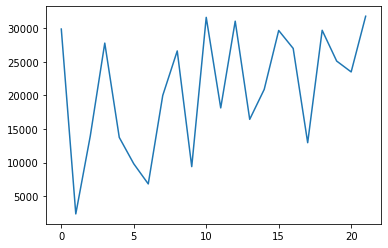

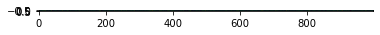

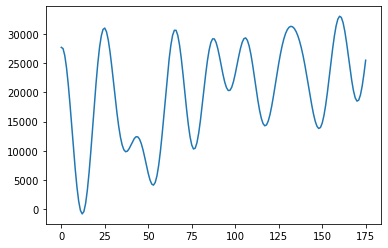

In [108]:
%matplotlib inline
import numpy as np
import librosa

s = 192000

int32_data = np.random.rand(22050).astype('float64') * (2**15)
audio = librosa.core.resample(int32_data, 22050, s)
len(audio)
import matplotlib.pyplot as plt
plt.plot(int32_data[0:22]) # Plot list. x-values assumed to be [0, 1, 2, 3]
plt.show()  # Optional when using IPython interpreter

plt.imshow(int32_data[None, 0:1000])
plt.show()

plt.plot(audio[0:22*(s//22050)]) # Plot list. x-values assumed to be [0, 1, 2, 3]
plt.show()  # Optional when using IPython interpreter

In [122]:
import os
import numpy as np
import soundfile as sf
import librosa
import scipy
from scipy import signal
from tqdm import tqdm

filt_type        = ['hp' ,'hp' ,'lp' ]
filt_cutoff_freq = [150  ,40   ,18000]
filt_order       = [4    ,9    ,9    ]
trim_top_db   =[46]*5
trim_window_length  =[9600,4800,2400,1200,600]
trim_hop_length  =[1200,600 ,300 ,150 ,150]
trim_ref    =[np.amax]*5
trim_preemphasis_strength =[0.0]*5
trim_margin_left =[0]*5
trim_margin_right =[0]*5
SAMPLE_RATE=48000
MIN_SAMPLE_RATE=22050
BIT_DEPTH=2
ignore_dirs=["Noise samples","_Noisy_","_Very Noisy_"]
skip_existing=False

file_path = r"H:\ClipperDatasetV2\SlicedDialogue\Other\Dr. Who\Dead Air (44.1 kHz)\00_09_11_Doctor_Neutral__Dangerous phenomenon, caused by radio stations out at sea. All you need is.flac"

out_path = file_path.replace(".flac",".wav")
if skip_existing and os.path.exists(out_path):
    raise
if any([filter_dir in file_path for filter_dir in ignore_dirs]):
    raise
if file_path.endswith("_mic1.flac"):
    os.rename(file_path, file_path.replace("_mic1.flac",".flac"))
if file_path.endswith("_mic2.flac"):
    raise

native_sound, native_SR = sf.read(file_path, always_2d=True)
print(native_SR)
print(SAMPLE_RATE)
native_sound = native_sound[:,0]# take first channel (either mono or left typically)
native_sound = np.asfortranarray(native_sound).astype('float64') # and ensure the audio is contiguous

if SAMPLE_RATE < MIN_SAMPLE_RATE: # skip any files with SAMPLE_RATE below the minimum
    raise
if native_SR != SAMPLE_RATE: # ensure all audio is same Sample Rate
    try:
        sound = librosa.core.resample(native_sound, native_SR, SAMPLE_RATE)
        print(f"Sound resampled New Len: {len(sound)}, old Len: {len(native_sound)}")
    except ValueError as ex:
        print(ex)
        print(file_path)
        print(native_SR)
        print(len(native_sound))
        raise ValueError(ex)
else:
    sound = native_sound

if max(np.amax(native_sound), -np.amin(native_sound)) > (2**23): # if samples exceed values possible at 24 bit
    sound = (sound / 2**(31-15))#.astype('int16') # change bit depth from 32 bit to 16 bit
elif max(np.amax(native_sound), -np.amin(native_sound)) > (2**15): # if samples exceed values possible at 16 bit
    sound = (sound / 2**(23-15))#.astype('int16') # change bit depth from 24 bit to 16 bit

# apply audio filters
for type_, freq_, order_ in zip(filt_type, filt_cutoff_freq, filt_order): # eg[ ['lp'], [40], [10] ] # i.e [type, freq, strength]
    sos = signal.butter(order_, freq_, type_, fs=SAMPLE_RATE, output='sos') # calcuate filter somethings
    sound = signal.sosfilt(sos, sound) # apply filter

original_len = len(sound)
# apply audio trimming
for i, (margin_left_, margin_right_, top_db_, window_length_, hop_length_, ref_, preemphasis_strength_) in enumerate(zip(trim_margin_left, trim_margin_right, trim_top_db, trim_window_length, trim_hop_length, trim_ref, trim_preemphasis_strength)):
    if preemphasis_strength_:
        sound_filt = librosa.effects.preemphasis(sound, coef=preemphasis_strength_)
        _, index = librosa.effects.trim(sound_filt, top_db=top_db_, frame_length=window_length_, hop_length=hop_length_, ref=ref_) # gonna be a little messed up for different sampling rates
    else:
        _, index = librosa.effects.trim(sound, top_db=top_db_, frame_length=window_length_, hop_length=hop_length_, ref=ref_) # gonna be a little messed up for different sampling rates
    sound = sound[max(index[0]-margin_left_, 0):index[1]+margin_right_]
    assert len(sound), f"Audio trimmed to 0 length by pass {i+1}\nconfig = {[margin_left_, margin_right_, top_db_, window_length_, hop_length_, ref_]}\nFile_Path = '{file_path}'"

print(f"Written to {out_path}")
sf.write(out_path, sound, SAMPLE_RATE)

44100
48000
Sound resampled New Len: 479934, old Len: 440939
Written to H:\ClipperDatasetV2\SlicedDialogue\Other\Dr. Who\Dead Air (44.1 kHz)\00_09_11_Doctor_Neutral__Dangerous phenomenon, caused by radio stations out at sea. All you need is.wav


In [123]:
3*(2**11)

6144

In [72]:
np.ones((64,2))[:].shape

(64,)

In [73]:
list(zip([],[]))

[]

In [68]:
[30,] + [36]*5

[30, 36, 36, 36, 36, 36]

In [17]:
training_seconds= (16000/22050)*13100*1000
sample_rate     = 48000

segment_length  = 6600
batch_size      = 8
num_gpus        = 3

completed_iters = 0
time_per_iter   = 2.75
# 12 Flow, 512 Channel, 8 n_group.

estimate_wg(training_seconds, sample_rate, segment_length, batch_size, num_gpus, completed_iters, time_per_iter)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Ref LR: 3.79e-05
Approx Learning/Hr: 1.200
	Root-scale: 0.661Traceback (most recent call last):
  File "C:\Users\Administrator\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-b9ff33884664>", line 12, in <module>
    estimate_wg(training_seconds, sample_rate, segment_length, batch_size, num_gpus, completed_iters, time_per_iter)
  File "<ipython-input-1-0e477a62e24e>", line 11, in estimate_wg
    print(f"Ref LR: {((segment_length/sample_rate)*batch_size*num_gpus)/(174149.65986394554*0.5):0.2e}\nApprox Learning/Hr: {(((segment_length/sample_rate)*batch_size*num_gpus))/time_per_iter:0.3f}\n\tRoot-scale: {(((segment_length/sample_rate)*batch_size*num_gpus)**0.5)/time_per_iter:0.3f}")
  File "C:\Users\Administrator\AppData\Roaming\Python\Python37\site-packages\ipykernel\iostream.py", line 402, in write
    self.pub_thread.schedule(lambda : self._buffer.write

KeyboardInterrupt: 

In [3]:
training_seconds= (16000/22050)*13100*1000
sample_rate     = 48000

segment_length  = 24000
batch_size      = 8
num_gpus        = 3

completed_iters = 0
time_per_iter   = 5.52
# 12 Flow, 512 Channel, 8 n_group.

estimate_wg(training_seconds, sample_rate, segment_length, batch_size, num_gpus, completed_iters, time_per_iter)

Ref LR: 1.38e-04
Approx Learning/Hr: 2.174
	Root-scale: 0.628
   50.61 Days Total.     (aka 1.215e+03 Hrs)
   50.61 Days Remaining. (aka 1.215e+03 Hrs)
    0.00 Days Elapsed.   (aka   0.0 Hrs)
  792139 Iters Remaining.
   652.2 Iterations per Hr.
 15652.2 Iterations per Day.
109565.2 Iterations per Week.


In [4]:
training_seconds= (16000/22050)*13100*1000
sample_rate     = 48000

segment_length  = 9000
batch_size      = 2
num_gpus        = 3

completed_iters = 0
time_per_iter   = 1.37
# 12 Flow, 512 Channel, 8 n_group, Mem-efficient Disabled

estimate_wg(training_seconds, sample_rate, segment_length, batch_size, num_gpus, completed_iters, time_per_iter)

Ref LR: 1.29e-05
Approx Learning/Hr: 0.821
	Root-scale: 0.774
  133.98 Days Total.     (aka 3.215e+03 Hrs)
  133.98 Days Remaining. (aka 3.215e+03 Hrs)
    0.00 Days Elapsed.   (aka   0.0 Hrs)
 8449483 Iters Remaining.
  2627.7 Iterations per Hr.
 63065.7 Iterations per Day.
441459.9 Iterations per Week.


In [5]:
training_seconds= (16000/22050)*13100*1000
sample_rate     = 48000

segment_length  = 9000
batch_size      = 3
num_gpus        = 3

completed_iters = 0
time_per_iter   = 1.37
# 12 Flow, 512 Channel, 12 n_group, Mem-efficient Disabled

estimate_wg(training_seconds, sample_rate, segment_length, batch_size, num_gpus, completed_iters, time_per_iter)

Ref LR: 1.94e-05
Approx Learning/Hr: 1.232
	Root-scale: 0.948
   89.32 Days Total.     (aka 2.144e+03 Hrs)
   89.32 Days Remaining. (aka 2.144e+03 Hrs)
    0.00 Days Elapsed.   (aka   0.0 Hrs)
 5632989 Iters Remaining.
  2627.7 Iterations per Hr.
 63065.7 Iterations per Day.
441459.9 Iterations per Week.


In [6]:
training_seconds= (16000/22050)*13100*1000
sample_rate     = 48000

segment_length  = 1800
batch_size      = 16
num_gpus        = 3

completed_iters = 31680
time_per_iter   = 1.42
# 12 Flow, 512 Channel, 12 n_group, Mem-efficient Disabled

estimate_wg(training_seconds, sample_rate, segment_length, batch_size, num_gpus, completed_iters, time_per_iter)

Ref LR: 2.07e-05
Approx Learning/Hr: 1.268
	Root-scale: 0.945
   86.79 Days Total.     (aka 2.083e+03 Hrs)
   86.27 Days Remaining. (aka 2.071e+03 Hrs)
    0.52 Days Elapsed.   (aka  12.5 Hrs)
 5249247 Iters Remaining.
  2535.2 Iterations per Hr.
 60845.1 Iterations per Day.
425915.5 Iterations per Week.


In [7]:
training_seconds= (16000/22050)*13100*1000
sample_rate     = 48000

segment_length  = 6000
batch_size      = 48
num_gpus        = 3

completed_iters = 107500
time_per_iter   = 0.66
# 12 Flow, 9 Layers, 512 Channel, 120 n_group, Mem-efficient Disabled

estimate_wg(training_seconds, sample_rate, segment_length, batch_size, num_gpus, completed_iters, time_per_iter)

Ref LR: 2.07e-04
Approx Learning/Hr: 27.273
	Root-scale: 6.428
    4.03 Days Total.     (aka 96.82 Hrs)
    3.21 Days Remaining. (aka 77.11 Hrs)
    0.82 Days Elapsed.   (aka 19.71 Hrs)
  420593 Iters Remaining.
  5454.5 Iterations per Hr.
130909.1 Iterations per Day.
916363.6 Iterations per Week.


In [8]:
training_seconds= (16000/22050)*13100*1000
sample_rate     = 48000

segment_length  = 24000
batch_size      = 32
num_gpus        = 3

completed_iters = 264000
time_per_iter   = 1.34
# 16 Flow, 5 Layer, 384 Channel, 120 n_group, Mem-efficient Disabled

estimate_wg(training_seconds, sample_rate, segment_length, batch_size, num_gpus, completed_iters, time_per_iter)

Ref LR: 5.51e-04
Approx Learning/Hr: 35.821
	Root-scale: 5.170
    3.07 Days Total.     (aka 73.71 Hrs)
   -1.02 Days Remaining. (aka -24.55 Hrs)
    4.09 Days Elapsed.   (aka 98.27 Hrs)
  -65965 Iters Remaining.
  2686.6 Iterations per Hr.
 64477.6 Iterations per Day.
451343.3 Iterations per Week.


In [9]:
training_seconds= (16000/22050)*13100*1000
sample_rate     = 48000

segment_length  = 24000
batch_size      = 32
num_gpus        = 3

completed_iters = 278000
time_per_iter   = 1.59
# 24 Flow, 5 Layer, 384 Channel, 120 n_group, Mem-efficient Disabled

estimate_wg(training_seconds, sample_rate, segment_length, batch_size, num_gpus, completed_iters, time_per_iter)

Ref LR: 5.51e-04
Approx Learning/Hr: 30.189
	Root-scale: 4.357
    3.64 Days Total.     (aka 87.47 Hrs)
   -1.47 Days Remaining. (aka -35.32 Hrs)
    5.12 Days Elapsed.   (aka 122.8 Hrs)
  -79965 Iters Remaining.
  2264.2 Iterations per Hr.
 54339.6 Iterations per Day.
380377.4 Iterations per Week.


In [2]:
training_seconds= (16000/22050)*13100*1000
sample_rate     = 48000

segment_length  = 24000
batch_size      = 8
num_gpus        = 3

completed_iters = 165000
time_per_iter   = 4.08
# 48 Flow, 8 Layer, 256 Channel, 24 n_group, Mem-efficient

estimate_wg(training_seconds, sample_rate, segment_length, batch_size, num_gpus, completed_iters, time_per_iter)

Ref LR: 1.38e-04
Approx Learning/Hr: 2.941
	Root-scale: 0.849
   37.41 Days Total.     (aka 897.8 Hrs)
   29.61 Days Remaining. (aka 710.8 Hrs)
    7.79 Days Elapsed.   (aka 187.0 Hrs)
  627139 Iters Remaining.
   882.4 Iterations per Hr.
 21176.5 Iterations per Day.
148235.3 Iterations per Week.


In [3]:
training_seconds= (16000/22050)*13100*1000
sample_rate     = 48000

segment_length  = 24000
batch_size      = 24
num_gpus        = 3

completed_iters = 143000
time_per_iter   = 8.6
# 48 Flow, 8 Layer, 256 Channel, 24 n_group, Mem-efficient

estimate_wg(training_seconds, sample_rate, segment_length, batch_size, num_gpus, completed_iters, time_per_iter)

Ref LR: 4.13e-04
Approx Learning/Hr: 4.186
	Root-scale: 0.698
   26.28 Days Total.     (aka 630.8 Hrs)
   12.05 Days Remaining. (aka 289.2 Hrs)
   14.23 Days Elapsed.   (aka 341.6 Hrs)
  121046 Iters Remaining.
   418.6 Iterations per Hr.
 10046.5 Iterations per Day.
 70325.6 Iterations per Week.


In [3]:
import torch
x = torch.rand(16,160,1000)

In [56]:
import numpy as np
import math
from numpy import exp

def sigmoid(x):
  return 1 / (1 + exp(-x))

In [35]:
%%timeit
x = np.random.rand(256)

3.48 µs ± 14.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [57]:
%%timeit
x = np.random.rand(256)
for i in range(2000):
    x = np.maximum(sigmoid(x), sigmoid(x))

29.8 ms ± 332 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [37]:
%%timeit
x_torch = torch.rand(256)

5.32 µs ± 33.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [38]:
%%timeit
x_torch = torch.rand(256)
for i in range(2000):
    x = x_torch.numpy()
    x = np.maximum(x, x)

2.97 ms ± 17.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [39]:
%%timeit
x = torch.rand(256)

5.41 µs ± 46.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [58]:
%%timeit
x = torch.rand(256)
for i in range(2000):
    x = torch.max(torch.sigmoid(x), torch.sigmoid(x))

37.6 ms ± 55.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Pytorch GPU

In [41]:
%%timeit
x = torch.rand(256, device='cuda')

73 µs ± 173 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [13]:
%%timeit
for i in range(2000):
    x = torch.rand(256, device='cuda')
    x = x.cpu()
    x = torch.max(torch.sigmoid(x), torch.sigmoid(x))
    x = x.min() > 0.5

352 ms ± 5.25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%%timeit
for i in range(2000):
    x = torch.rand(256, device='cuda')
    x = torch.max(torch.sigmoid(x), torch.sigmoid(x))
    x = x.min() > 0.5

1.09 s ± 7.89 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
x = torch.rand(256).float()
x.min()

tensor(0.0056)

Pytorch JIT compile inner code of loop

In [46]:
@torch.jit.script
def get_max(x, y):
    return torch.max(x, y)

In [51]:
%%timeit
x = torch.rand(256, device='cuda')
for i in range(2000):
    x = get_max(x, x)

175 ms ± 625 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Pytorch JIT compile entire loop

In [49]:
@torch.jit.script
def get_loop(x):    
    for i in range(2000):
        x = torch.max(x, x)
    return x

In [50]:
%%timeit
x = torch.rand(256, device='cuda')
x = get_loop(x)

146 ms ± 703 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [4]:
training_seconds= (16000/22050)*13100*1000
sample_rate     = 48000

segment_length  = 24000
batch_size      = 48
num_gpus        = 3

completed_iters = 5000
time_per_iter   = 15.6
# 48 Flow, 8 Layer, 256 Channel, 24 n_group, Mem-efficient

estimate_wg(training_seconds, sample_rate, segment_length, batch_size, num_gpus, completed_iters, time_per_iter)

Ref LR: 8.27e-04
Approx Learning/Hr: 4.615
	Root-scale: 0.544
   23.84 Days Total.     (aka 572.1 Hrs)
   22.93 Days Remaining. (aka 550.4 Hrs)
    0.90 Days Elapsed.   (aka 21.67 Hrs)
  127023 Iters Remaining.
   230.8 Iterations per Hr.
  5538.5 Iterations per Day.
 38769.2 Iterations per Week.


In [25]:
class LossExplosionError(Exception):
    pass

In [26]:
raise LossExplosionError("Training Loss > 1e3")

LossExplosionError: Training Loss > 1e3

In [58]:
(2**4)*3*120

5760

In [59]:
[print(f"{round(5000/x,2):<10}|{round(5000/x*2,2):<10}|{round(5000/x*3,2):<10}") for x in range(1,21)]

5000.0    |10000.0   |15000.0   
2500.0    |5000.0    |7500.0    
1666.67   |3333.33   |5000.0    
1250.0    |2500.0    |3750.0    
1000.0    |2000.0    |3000.0    
833.33    |1666.67   |2500.0    
714.29    |1428.57   |2142.86   
625.0     |1250.0    |1875.0    
555.56    |1111.11   |1666.67   
500.0     |1000.0    |1500.0    
454.55    |909.09    |1363.64   
416.67    |833.33    |1250.0    
384.62    |769.23    |1153.85   
357.14    |714.29    |1071.43   
333.33    |666.67    |1000.0    
312.5     |625.0     |937.5     
294.12    |588.24    |882.35    
277.78    |555.56    |833.33    
263.16    |526.32    |789.47    
250.0     |500.0     |750.0     


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [60]:
training_seconds= (16000/22050)*13100*1000
sample_rate     = 48000

segment_length  = 24000
batch_size      = 8
num_gpus        = 3

completed_iters = 0
time_per_iter   = 1.32
# 12 Flow, 512 Channel, 120 n_group.

estimate_wg(training_seconds, sample_rate, segment_length, batch_size, num_gpus, completed_iters, time_per_iter)

Ref LR: 8.30e-05
Approx Learning/Hr: 2.624
   12.10 Days Total.     (aka 290.5 Hrs)
   12.10 Days Remaining. (aka 290.5 Hrs)
    0.00 Days Elapsed.   (aka   0.0 Hrs)
  792139 Iters Remaining.
 65454.5 Iterations per Day.
458181.8 Iterations per Week.


In [61]:
training_seconds= (16000/22050)*13100*1000
sample_rate     = 48000

segment_length  = 24000
batch_size      = 16
num_gpus        = 3

completed_iters = 0
time_per_iter   = 1.7
# 12 Flow, 512 Channel, 120 n_group.

estimate_wg(training_seconds, sample_rate, segment_length, batch_size, num_gpus, completed_iters, time_per_iter)

Ref LR: 1.17e-04
Approx Learning/Hr: 2.882
    7.79 Days Total.     (aka 187.0 Hrs)
    7.79 Days Remaining. (aka 187.0 Hrs)
    0.00 Days Elapsed.   (aka   0.0 Hrs)
  396070 Iters Remaining.
 50823.5 Iterations per Day.
355764.7 Iterations per Week.


In [62]:
training_seconds= (16000/22050)*13100*1000
sample_rate     = 48000

segment_length  = 24000
batch_size      = 24
num_gpus        = 3

completed_iters = 0
time_per_iter   = 2.07
# 12 Flow, 512 Channel, 120 n_group.

estimate_wg(training_seconds, sample_rate, segment_length, batch_size, num_gpus, completed_iters, time_per_iter)

Ref LR: 1.44e-04
Approx Learning/Hr: 2.899
    6.33 Days Total.     (aka 151.8 Hrs)
    6.33 Days Remaining. (aka 151.8 Hrs)
    0.00 Days Elapsed.   (aka   0.0 Hrs)
  264046 Iters Remaining.
 41739.1 Iterations per Day.
292173.9 Iterations per Week.


In [63]:
120*5

600

In [64]:
8*5

40